In [1]:
import pandas as pd
import numpy as np
import matplotlib
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
import pyomo.util.infeasible as infeas
from idaes.core.util.model_statistics import *
import matplotlib.pyplot as plt
from truck_pipe_cost_functions import truck_costing, pipe_costing
from watertap3.utils.post_processing import get_results_table

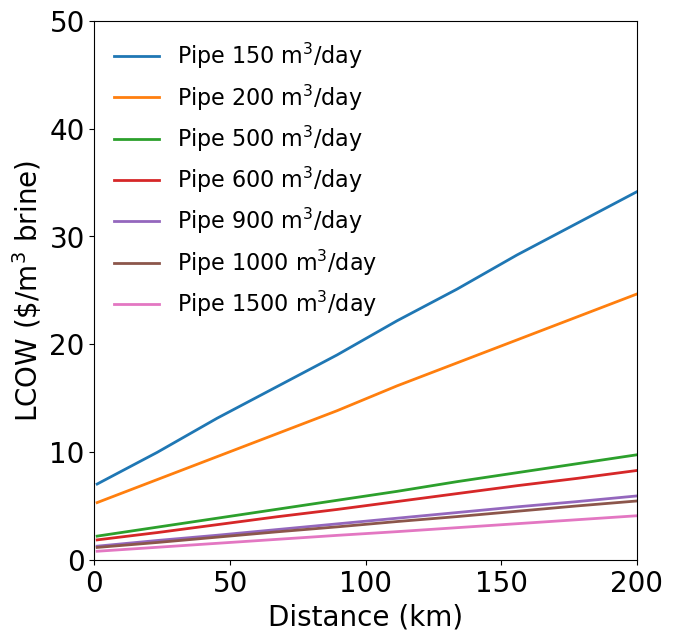

In [2]:
distance_input = np.linspace(1,200,10)
volume_input = [150,200,500,600,900,1000,1500]
output_pipe = []
output_truck_TX =[]
output_truck_CA =[]
output_truck_NM =[]

for d in distance_input:
    cost_truck_TX = truck_costing(d,wacc=0.1)
    cost_truck_CA = truck_costing(d,state='CA',wacc=0.1)
    cost_truck_NM = truck_costing(d,state='NM',wacc=0.1)
    output_truck_TX.append(cost_truck_TX)
    output_truck_CA.append(cost_truck_CA)
    output_truck_NM.append(cost_truck_NM)

for vol in volume_input:
    output_pipe_row = []
    for d in distance_input:
        cost_pipe = pipe_costing(vol,d,pump_power=20,pumping_velocity=2.7,hour_storage = 6)
        output_pipe_row.append(cost_pipe)
    output_pipe.append(output_pipe_row)

fig, ax = plt.subplots(figsize = (7,7))

for i in range(0,len(volume_input)):
    ax.plot(distance_input,output_pipe[i],label='Pipe '+ str(volume_input[i]) + r' ${\rm m^3}$/day',linewidth=2)
# ax.plot(distance_input,output_truck_TX,label = 'Truck (Texas)',linestyle= '--',linewidth=2)
# ax.plot(distance_input,output_truck_CA,label = 'Truck (California)',linestyle= '--',color='blue',linewidth=2)
# ax.plot(distance_input,output_truck_NM,label = 'Truck (New Mexico)',linestyle= '--',color='brown',linewidth=2)
ax.legend(fontsize = 16,frameon=False)

ax.set_xlabel("Distance (km)",fontsize = 20)
ax.set_ylabel(r'LCOW (\$/m${^3}$ brine)',fontsize = 20)
ax.set_xlim([0,200])
ax.set_ylim([0,50])

ax.tick_params(axis='both', which='major', labelsize=20)

Text(0, 0.5, 'LCOW ($/m3 brine)')

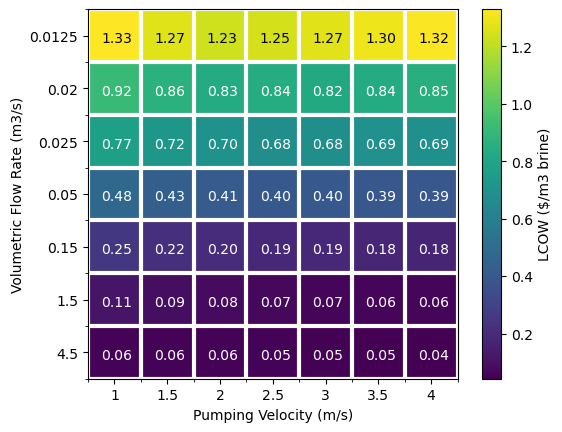

In [6]:
# Pumping velocity and capacity sensitivity
vol_list = [0.0125,0.02, 0.025, 0.05,0.15,1.5,4.5]
velocity_list = [1, 1.5,2,2.5,3,3.5,4]
lcow = np.zeros(shape=(len(vol_list),len(velocity_list)))
for i in range(0,len(vol_list)):
    for j in range(0,len(velocity_list)):
         lcow[i,j] = pipe_costing(vol_list[i]*3600*24,10,pumping_velocity=velocity_list[j],pump_power=24)

# lcow
fig,ax=plt.subplots()
im = ax.imshow(lcow)

ax.set_xticks(np.arange(lcow.shape[1] + 1) - 0.5, minor = True)
ax.set_yticks(np.arange(lcow.shape[0] + 1) - 0.5, minor = True)
ax.grid(which = "minor", color = "w", linestyle = '-', linewidth = 3)
ax.set_xticks(np.arange(len(velocity_list)), labels = velocity_list)
ax.set_yticks(np.arange(len(vol_list)), labels = vol_list)

valfmt="{x:.2f}"
# Get the formatter in case a string is supplied
if isinstance(valfmt, str):
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

textcolors = ("black", "white")
for i in range(0,len(vol_list)):
    for j in range(0,len(velocity_list)):
        if lcow[i, j]>1:
            c = 'black'
        else:
            c= 'white'
        im.axes.text(j-0.25, i+0.125, valfmt(lcow[i, j], None),c=c)
ax.set_ylabel('Volumetric Flow Rate (m3/s)')
ax.set_xlabel('Pumping Velocity (m/s)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('LCOW ($/m3 brine)')

36.272351650533906 0.00024421542341341543 43832.039626919905
36.272351650533906 0.00024421542341341543 43832.039626919905
36.272351650533906 0.00024421542341341543 43832.039626919905
36.272351650533906 0.00024421542341341543 43832.039626919905
51.29685164335117 0.00017268638196596997 55414.682818752815
51.29685164335117 0.00017268638196596997 55414.682818752815


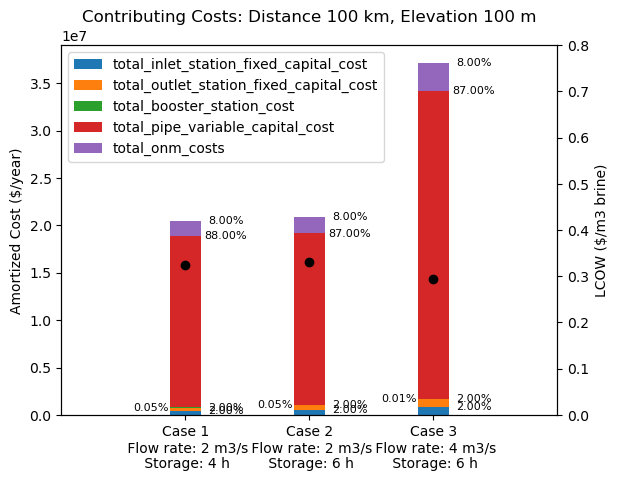

In [4]:
flow_rates = [2,2,4]
hours_storage = [4,6,6]

def get_transport_cost_breakdown(flow_rates,hours_storage):
    # Get the cost breakdown
    breakdown = []
    lcow = []
    for i in range(0,len(flow_rates)):
        breakdown.append(pipe_costing(flow_rates[i]*3600*24,100,elev_gain=100,hour_storage=hours_storage[i],cost_break_down=True))
        lcow.append(pipe_costing(flow_rates[i]*3600*24,100,elev_gain=100,hour_storage=hours_storage[i],cost_break_down=False))
    cost_breakdown_df = pd.DataFrame(breakdown)

    return cost_breakdown_df,lcow

cost_breakdown_df,lcow = get_transport_cost_breakdown(flow_rates,hours_storage)
# print(cost_breakdown_df.transpose()[-7:-2])

def print_func(val):
    if val>0.1:
        return '{:.2f}%'.format(round(val))
    else:
        return '{:.2f}%'.format(val)
    

def plot_transport_cost_breakdown(cost_breakdown_df,lcow):
    # Make table of bottom and percentage for annotation
    # Percentage matrix
    cost_breakdown_df_transposed = cost_breakdown_df.transpose()[-7:-2]
    cost_breakdown_df_transposed_percent = cost_breakdown_df_transposed
    for i in range(0,len(cost_breakdown_df.transpose().columns)):
        cost_breakdown_df_transposed_percent[i] = cost_breakdown_df_transposed[i]/cost_breakdown_df_transposed[i].sum()*100
    
    # Bottoms
    bottoms = cost_breakdown_df.transpose()[-7:-2].cumsum()

    fig, ax = plt.subplots()
    cost_breakdown_df.transpose()[-7:-2].transpose().plot.bar(ax = ax,stacked=True,width = 0.25)
    for i in range(0,len(cost_breakdown_df.transpose()[-7:-2].index)):
        for j in range(0,len(cost_breakdown_df.index)):
            ax.text(ax.patches[j].get_x() + 0.45 - (cost_breakdown_df_transposed_percent.values[i,j] < 0.1)*0.6,
                    bottoms.values[i][j],
                    print_func(cost_breakdown_df_transposed_percent.values[i,j]), 
                    ha='center',
                    va='center',
                    fontdict={'fontsize' : 8})
    ax.set_xlim([-1,3])
    ax.set_title('Contributing Costs: Distance 100 km, Elevation 100 m')
    ax.set_xticklabels(['Case 1\n Flow rate: 2 m3/s\n Storage: 4 h', 'Case 2\n Flow rate: 2 m3/s\n Storage: 6 h', 'Case 3\n Flow rate: 4 m3/s\n Storage: 6 h'],rotation = 0)
    ax.set_ylabel('Amortized Cost ($/year)')
    ax0 = ax.twinx()
    ax0.scatter([0,1,2], lcow, c='black')
    ax0.set_ylim([0,0.8])
    ax0.set_ylabel('LCOW ($/m3 brine)')


plot_transport_cost_breakdown(cost_breakdown_df,lcow)
    

In [5]:
cost_breakdown_df

,storage_capacity,storage_tank_capital_cost,fitting_valve_capital_cost,inlet_pump_capital_cost,outlet_pump_cost_capital_cost,road_access_capital_cost,building_foundation_capital_cost,booster_pump_capital_cost,booster_pump_installation_capital_cost,n_booster_pumps,...,labor_cost,total_electricity_cost,pipe_road_access_cost_variable_cost,total_inlet_station_fixed_capital_cost,total_outlet_station_fixed_capital_cost,total_booster_station_cost,total_pipe_variable_capital_cost,total_onm_costs,capital_recovery_factor,plant_utilization
0,28800.0,382780.645721,3791.706058,1508.998277,430.22511,424.0,1469.0,1508.998277,150.899828,2,...,21654.32171,27059.956940,346878.3,389974.350057,388471.576889,10097.511710,1.809569e+07,1.627809e+06,0.065051,0.958904
1,43200.0,512742.648228,3791.706058,1508.998277,430.22511,424.0,1469.0,1508.998277,150.899828,2,...,21654.32171,27059.956940,346878.3,519936.352563,518433.579396,10097.511710,1.809569e+07,1.747679e+06,0.065051,0.958904
2,86400.0,845125.093296,5456.013173,1508.998277,430.22511,424.0,1469.0,1508.998277,150.899828,1,...,21654.32171,18039.971293,346878.3,853983.104746,852480.331578,5547.375105,3.248871e+07,2.952003e+06,0.065051,0.958904


In [6]:
pipe_costing(480, 160, hour_storage=4, pumping_velocity=2.7, cost_break_down=True)

2.0151306472518837 0.0035606608733675963 4212.701098942492


{'storage_capacity': 79.99999999999999,
 'storage_tank_capital_cost': 5495.849215025545,
 'fitting_valve_capital_cost': 182.30497988226114,
 'inlet_pump_capital_cost': 1508.9982773991496,
 'outlet_pump_cost_capital_cost': 430.22510980801303,
 'road_access_capital_cost': 423.99999999999994,
 'building_foundation_capital_cost': 1469.0,
 'booster_pump_capital_cost': 1508.9982773991496,
 'booster_pump_installation_capital_cost': 150.89982773991497,
 'n_booster_pumps': 37,
 'booster_power_line_variable_capital_cost': 37895.062991664316,
 'pipe_diameter': 2.0151306472518837,
 'pipe_cost': 58229.478823088924,
 'pipe_construction_cost': 558283.4138164913,
 'pipe_maintenance_cost': 291.1473941154446,
 'pump_maintenance_cost': 2174.714041223739,
 'labor_cost': 21654.321709522465,
 'total_electricity_cost': 342759.4545730473,
 'pipe_road_access_cost_variable_cost': 346878.3,
 'total_inlet_station_fixed_capital_cost': 9080.152472306956,
 'total_outlet_station_fixed_capital_cost': 7577.379304715819

In [ ]:
a = 40073.42661387725
b = 0.866701037568153
flow_in = 4.5*22.82
a*flow_in ** b

2219473.7752948166

In [ ]:
# Pumping velocity sensitivity
print(pipe_costing(4.5*10*3600*24,10,pumping_velocity=5,pump_power=20))
print(pipe_costing(0.0015*3600*24,10,pumping_velocity=1.5,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=1.5,pump_power=20))

print(pipe_costing(0.0015*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=40))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=10,pump_power=20))


0.01146495409277592
8.63027740750741
0.05443473248960341
9.709572082145057
0.04653253589757084
0.04659251809843447
0.029606227961637758


In [ ]:
# Pump power

print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=20))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=40))
print(pipe_costing(4.5*3600*24,10,pumping_velocity=3,pump_power=500))

pump_power = 40 # kW
N = 1
electricity =  (N+1)*pump_power
electricity_rate = 0.06 #$/kwh
days_operation = 350
total_electricity_cost = electricity_rate * electricity *  days_operation * 24

total_electricity_cost

0.04653253589757084
0.04659251809843447
0.04791859053383311


40320.0

In [ ]:
# Pipe diameter
pipe_csa = 4.5/3
pipe_diameter = 2 * (pipe_csa/np.pi)**0.5
print(pipe_diameter*39.3701) # m to inches

print(pipe_costing(45*3600*24, 10, pumping_velocity=3, pump_power=20))

54.4085568564057
0.01146495409277592


In [ ]:
# Calculating the range of pump power to find the average pump power which is fixed in the transport function
def pump_power(flow_in, lift_height):
    flow_in_gpm = flow_in*1.585*1e4 #m3/s to gpm
    lift_height_ft = lift_height*3.28084  # m to ft
    return (0.746 * flow_in_gpm * lift_height_ft/ (3960 * 0.9 * 0.9)) 

print(pump_power(4.5,10))


544.2337295735128


In [ ]:
wacc = 0.05
plant_lifetime_yrs = 30
crf = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
plant_utilization = 350/365

In [ ]:
a = 0.00344
b = 0.72093
flow = 4.5 #m3/s
storage_duration = 24 #h
storage_capacity = storage_duration*flow*3600 #convert to m3/h
storage_tank_capital_cost = a*storage_capacity**b

storage_tank_capital_cost

36843407.74974399

In [7]:
# Checking costs from Zhou and Tol 2005
# Gruen 78 km pipeline, 75 million m3 per year, 300 m elevation. Estimate 25-34 cent/m3
print('LCOW',pipe_costing(75e6/365,78,elev_gain=300,hour_storage = 24))
# Uche 900 km, 1000 million m3 per year, 36 cent/m3
print('LCOW',pipe_costing(1000e6/365,900,elev_gain = 10,hour_storage = 24))
# Hahnemann 550 km, 1800 million m3 per year, 750 elevation. Estimate 74 cent/m3. This is an aquaduct
print('LCOW',pipe_costing(1800e6/365,550,elev_gain=750,hour_storage = 24))

# Pootakham, from figure 1
print('LCOW',pipe_costing(156,100,hour_storage = 24)) # ~30 $/m3
print('LCOW',pipe_costing(250,100,hour_storage = 24)) # ~20-25 $/m3

#Marufazaman
print('LCOW',pipe_costing(150,200*1.6,hour_storage = 24)) # 40 $/m3
print('LCOW',pipe_costing(250,200*1.6,hour_storage = 24)) # 25-30 $/m3
print('LCOW',pipe_costing(1500,200*1.6,hour_storage = 24)) # 25-30 $/m3


39.55378454686265 0.00022395499742989977 24963.467033061483
LCOW 0.2954973799414185
63.0 0.0038839685240830936 3860.946803492753
LCOW 0.476580827219022
63.0 0.012584058018029226 1179.4590709480083
LCOW 0.1797202053394019
1.0898485313138406 0.008127980597318936 1845.4768441329904
LCOW 24.451168875598924
1.3796656397748033 0.006420590222121738 2336.2338131194474
LCOW 14.072468604583865
1.0686844092364827 0.008288946334366559 1809.6389323051735
LCOW 65.8700073092245
1.3796656397748033 0.006420590222121738 2336.233815570994
LCOW 35.36920371788962
3.3794768330987717 0.002621194981950194 5722.580764027884
LCOW 6.464883146568541
